In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<font color = Green> **The data for the following project has been taken from below mention link.** <Br> The Data contains monthly sales data of Beer, wine and Distilled Alcohol beverage for the year 1992 to 2019.<Br>
https://fred.stlouisfed.org/series/S4248SM144NCEN
    

In [3]:
Alcohol = pd.read_csv("Alcohol_Sales.csv", index_col="DATE", parse_dates=True)
Alcohol.index.freq = "MS"
Alcohol.head()


,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
# Renaming The Column

Alcohol.columns = ["Sales"]
Alcohol.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<AxesSubplot:title={'center':'Monthly Sales Data - Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales'}, xlabel='DATE'>

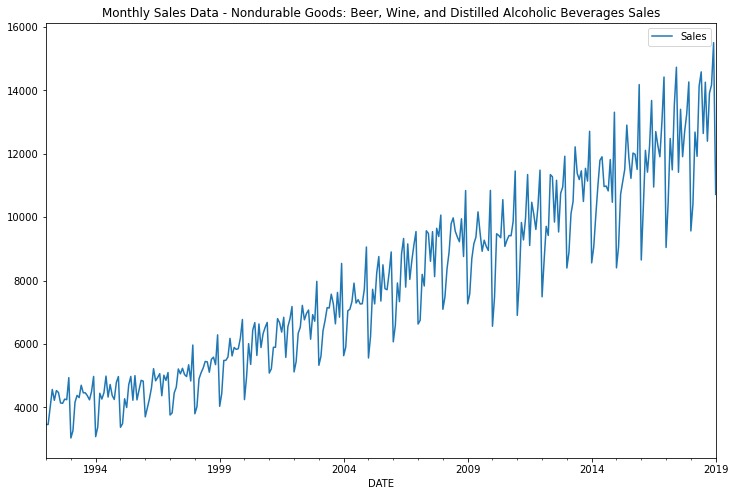

In [5]:
# Plotting the Sales

Alcohol.plot(figsize=(12,8), legend=True,
             title="Monthly Sales Data - Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales")

<font color=green> <b> From the above plot we can se there is some sort of Seasonality and Trend Component in the Data.

___

## <font color = Red> Decomposition<Br>
We will Decompose the Data into seperate components i.e. Trend, Seasonality, Noise

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
results = seasonal_decompose(Alcohol["Sales"])

<AxesSubplot:xlabel='DATE'>

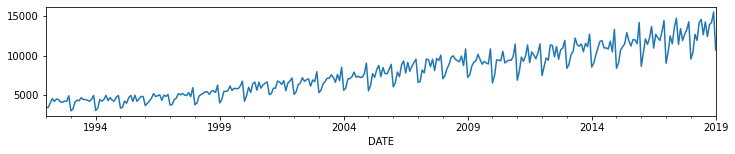

In [8]:
# Obeserved Component
results.observed.plot(figsize=(12,2))

<AxesSubplot:title={'center':'Trend Component'}, xlabel='DATE'>

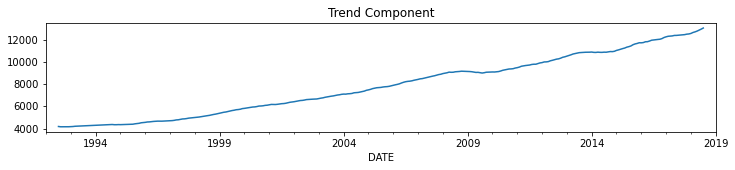

In [9]:
# Trend Component
results.trend.plot(figsize=(12,2), title="Trend Component")

<AxesSubplot:title={'center':'Seasonal Component'}, xlabel='DATE'>

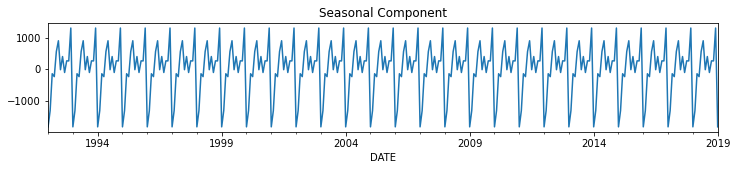

In [10]:
# Seasonal Component

results.seasonal.plot(figsize=(12,2), title="Seasonal Component")

<AxesSubplot:xlabel='DATE'>

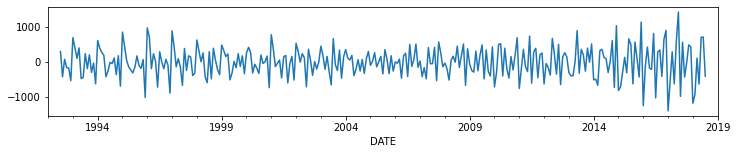

In [11]:
# Residual
results.resid.plot(figsize=(12,2))

___

## <font color = red> Train Test Split<Br>
We will Train our Neural Network on the Training Data.<Br>
We Can Forcast for as many days in future, But for evaluating our model we will Forcast for the Test Data and Compare the Results with the Actual Values.

In [12]:
len(Alcohol)

325

In [13]:
# We will train our model on 26 Years of monthly Sales i.e. 313 months
# We will test our model on last 12 months

train = Alcohol.iloc[:313]
test = Alcohol.iloc[313:]

___

## <font color = red> Scaling the Data<Br>
In Neural Networks As we calculate the Biases and weight, If your data is skewed, i.e. there is a huge difference between the minimum and Maximum value (In our Data the min is 4000 and max 15000), in this type of situation neurons get confused on what sort of valuse to be used for weights and Baises.

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Creating a Scaler object
scaler = MinMaxScaler()

# Scaler objet will perform 2 functions: 1. Fit: Finding a Max Value and 2. Transform: Dividing each element by Max value 

In [16]:
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET

scaler.fit(train)   # Find the Max Value in the Training Data Set

MinMaxScaler()

In [17]:
# Performaing Tranformation on Both Training and Test Data

scaled_train = scaler.transform(train)   
scaled_test = scaler.transform(test)

___

## <font color=red>Time Series Generator

**For Training the Neural Network we need to feed the Data in form of Batched along the Labels. [t1,t2,t3] --> [t4]. And to perform this task mannualy is a very complex.**

**This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.**

#### <font color = blue> Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [29]:
# define generator (TimeseriesGenerator Object)

n_input =2   
# How many Input we required to Predict the very next timestamp. 
# It define the what will be the length of you training sequence should be

n_features = 1
# How Many featureswe need to predict in the Future (How Many Columns in the Data Set).

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
# Batch Size is How many batch the Generator will take at once.
# Larger batch size leads to overfitting in the Neural Network

In [30]:
len(scaled_train)

313

In [31]:
len(generator) # n_input = 2

311

In [32]:
# What does the first batch look like?
X,y = generator[0]

In [33]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885]
Predict this y: 
 [[0.08299855]]


In [26]:
# For n_input = 4
print("For the Input = 4")

print("The Length of the Generator is",len(generator))
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

For the Input = 4
The Length of the Generator is 309
Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684]
Predict this y: 
 [[0.1017181]]


In [28]:
# For n_input = 2 and Batch Size=2
print("For the Input = 4")

print("The Length of the Generator is",len(generator))
X,y = generator[0]
print(f'Given the Array: \n{X}')
print(f'Predict this y: \n {y}')

For the Input = 4
The Length of the Generator is 311
Given the Array: 
[[[0.03658432]
  [0.03649885]]]
Predict this y: 
 [[0.08299855]]


In [34]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [35]:
# For n_input = 12 and Batch Size=1
print("For the Input size = 12")

print("The Length of the Generator is",len(train_generator))
X,y = train_generator[0]
print(f'Given the Array: \n{X.flatten()}')
print("The shape of the Input Array is", X.shape)
print(f'Predict this y: \n {y}')

For the Input size = 12
The Length of the Generator is 301
Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
The shape of the Input Array is (1, 12, 1)
Predict this y: 
 [[0.]]


___

## <font color = red> Creating A Model

In [36]:
from keras.models import Sequential
from keras.layers import Dense    # For the Output Layer
from keras.layers import LSTM

In [37]:
# define model
model = Sequential()

# Adding the Layer of the LSTM Model
# 150: LSTM neurons to be used
# relu: Rectified Linear Unit

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

# Aggregate All the Neuron Into the SIngle Prediction
model.add(Dense(1))

#Compilation
model.compile(optimizer='adam', loss='mse')

In [38]:
# Summary Of the Model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Fit the Model to the Training Generator
# 1 epochs is equal to single entire run through of all of your training data
# more epochs will leads to more time in training the model


model.fit_generator(train_generator,epochs=40)

Epoch 1/40
301/301 [==============================] - 2s 2ms/step - loss: 0.0256
Epoch 2/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0083
Epoch 3/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 4/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0077
Epoch 5/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0064
Epoch 6/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 7/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 8/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 9/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0033
Epoch 10/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 11/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 12/40
301/301 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 13/40
301/301 [====

In [40]:
# Checking the Model History

model.history.history.keys()

dict_keys(['loss'])

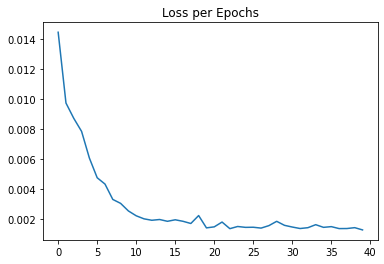

In [41]:
loss_per_epoch = model.history.history['loss']
plt.title("Loss per Epochs")
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

___

## <font color = red> Evaluating the Model On the Test data.<Br>

* Our RNN Model predict One time stamp Ahead, i.e. basically, our network recall 12 history steps and predict the step 13.<Br>
* We need the Last 12 points of the training Data to predict he point 1 of the Test Data.<Br>
* And we will continue this cycle to predict further in the test data.
 

In [42]:
first_eval_batch = scaled_train[-12:]

In [43]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [44]:
# Reshaping the First evaluation batch in the format network expects the input

first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [45]:
first_eval_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [46]:
# Predicting on the First evaluation Batch

model.predict(first_eval_batch)

array([[0.70491576]], dtype=float32)

In [47]:
# Actual value of the 1 timestamp of the Test Data

scaled_test[0]

array([0.63116506])

___

## <font color = red> Forcasting for the whole Test Data using RNN

In [48]:
# Empty list to Save the Test Prediction
test_predictions = []   

# Dynamic Initialisation for the First evaluation Batch
first_eval_batch = scaled_train[-n_input:]      

# Reshapping the evalutaion batch as per the Input Expected By the Neural Network
current_batch = first_eval_batch.reshape((1, n_input, n_features))      

In [49]:
current_batch.shape

(1, 12, 1)

In [50]:
current_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [51]:
#np.append(current_batch[:,1:,:],[[model.predict(current_batch)[0]]],axis=1)

In [52]:
#current_batch[:,1:,:]

In [53]:
#current_batch[:,:,:]

<font color = green> <b> Now let's put this logic in a for loop to predict into the future for the entire test range.


In [54]:
# Holding the predicted values
test_predictions = []

#Last n_input points from the Training Data set
first_eval_batch = scaled_train[-n_input:]

#Rehaping the evaluation batch to the format Model accept
current_batch = first_eval_batch.reshape((1, n_input, n_features))

#How far in the Future will the Model Forecast.
#
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
# Test Prediction

test_predictions

[array([0.70491576], dtype=float32),
 array([0.80947995], dtype=float32),
 array([0.7790407], dtype=float32),
 array([0.93723655], dtype=float32),
 array([0.99971473], dtype=float32),
 array([0.7606001], dtype=float32),
 array([0.9047129], dtype=float32),
 array([0.77718556], dtype=float32),
 array([0.86482215], dtype=float32),
 array([0.89812434], dtype=float32),
 array([0.9681581], dtype=float32),
 array([0.5973481], dtype=float32)]

In [56]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

___

## <font color = red> Inverse Transformations and Compare

In [57]:
true_predictions = scaler.inverse_transform(test_predictions)

In [58]:
true_predictions

array([[11277.80949903],
       [12501.10595679],
       [12144.99708188],
       [13995.73036885],
       [14726.66265166],
       [11929.26045322],
       [13615.2363975 ],
       [12123.29385793],
       [13148.55432439],
       [13538.15662086],
       [14357.48191464],
       [10019.37535155]])

In [59]:
test["Prediction"] = true_predictions

test

,Sales,Prediction
DATE,,
2018-02-01,10415,11277.809499
2018-03-01,12683,12501.105957
2018-04-01,11919,12144.997082
2018-05-01,14138,13995.730369
2018-06-01,14583,14726.662652
2018-07-01,12640,11929.260453
2018-08-01,14257,13615.236398
2018-09-01,12396,12123.293858
2018-10-01,13914,13148.554324


<AxesSubplot:title={'center':'Prediction Vs Actual'}, xlabel='DATE'>

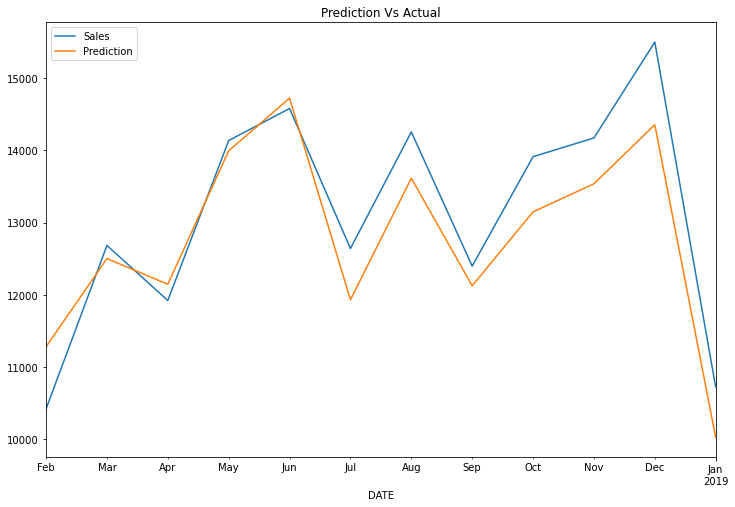

In [60]:
# Plotting the Actual and Predicted Values

test.plot(figsize=(12,8), title="Prediction Vs Actual")

___

## <font color = red> Saving and Loading Models

In [61]:
model.save('TSF using RNN.h5')